### 1.Business Understanding or Problem Statement

The stock market is a complex and dynamic environment that constantly evolves. Predicting the performance of individual stocks, such as Apple Inc. (AAPL), can be challenging. The goal of this project is to explore and analyze various financial and market trends to better understand the factors that influence the stock price of Apple Inc. (AAPL) and to build a predictive model that can accurately forecast its future performance.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from itertools import product
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from ipywidgets import IntProgress
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

### 2.Data Collection

In this study, we collected historical stock market data for Apple Inc. (AAPL) from Yahoo Finance. The data was sourced from the platform's finance website (finance.yahoo.com) and covered a period of [insert start and end dates]. The data included information on [insert specific data points such as opening price, closing price, highest price, lowest price, etc.]. The data was collected in [insert file format such as CSV, Excel, etc.] and processed to [insert any necessary cleaning or preprocessing steps]. The resulting dataset was then used for [insert the purpose of the study such as trend analysis, prediction, etc.].

In [2]:
raw_data = pd.read_csv("AAPL.csv")

In [3]:
df = raw_data.copy()

In [4]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-09,39.267502,39.472500,37.560001,39.102501,37.334156,282690400
1,2018-02-12,39.625000,40.972500,39.377499,40.677502,38.837936,243278000
2,2018-02-13,40.487499,41.187500,40.412498,41.084999,39.226994,130196800
3,2018-02-14,40.759998,41.884998,40.720001,41.842499,39.950245,162579600
4,2018-02-15,42.447498,43.272499,42.250000,43.247501,41.291702,204588800


### 3. Preprocessing

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1258 non-null   object 
 1   Open       1258 non-null   float64
 2   High       1258 non-null   float64
 3   Low        1258 non-null   float64
 4   Close      1258 non-null   float64
 5   Adj Close  1258 non-null   float64
 6   Volume     1258 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 68.9+ KB


In [6]:
# Set the date column as the index of the DataFrame
df.set_index('Date', inplace=True)


In [7]:
# Convert the index to a DatetimeIndex
df.index = pd.to_datetime(df.index)



In [8]:
# Resample the data to only include business days
df_resampled = df.resample("B").mean()

In [9]:
df.index

DatetimeIndex(['2018-02-09', '2018-02-12', '2018-02-13', '2018-02-14',
               '2018-02-15', '2018-02-16', '2018-02-20', '2018-02-21',
               '2018-02-22', '2018-02-23',
               ...
               '2023-01-26', '2023-01-27', '2023-01-30', '2023-01-31',
               '2023-02-01', '2023-02-02', '2023-02-03', '2023-02-06',
               '2023-02-07', '2023-02-08'],
              dtype='datetime64[ns]', name='Date', length=1258, freq=None)

In [10]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-02-09,39.267502,39.472500,37.560001,39.102501,37.334156,282690400
2018-02-12,39.625000,40.972500,39.377499,40.677502,38.837936,243278000
2018-02-13,40.487499,41.187500,40.412498,41.084999,39.226994,130196800
2018-02-14,40.759998,41.884998,40.720001,41.842499,39.950245,162579600
2018-02-15,42.447498,43.272499,42.250000,43.247501,41.291702,204588800


In [11]:
df.index

DatetimeIndex(['2018-02-09', '2018-02-12', '2018-02-13', '2018-02-14',
               '2018-02-15', '2018-02-16', '2018-02-20', '2018-02-21',
               '2018-02-22', '2018-02-23',
               ...
               '2023-01-26', '2023-01-27', '2023-01-30', '2023-01-31',
               '2023-02-01', '2023-02-02', '2023-02-03', '2023-02-06',
               '2023-02-07', '2023-02-08'],
              dtype='datetime64[ns]', name='Date', length=1258, freq=None)

In [12]:
df.shape

(1258, 6)

In [13]:
# all data is in the correct format
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2018-02-09 to 2023-02-08
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1258 non-null   float64
 1   High       1258 non-null   float64
 2   Low        1258 non-null   float64
 3   Close      1258 non-null   float64
 4   Adj Close  1258 non-null   float64
 5   Volume     1258 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.8 KB


In [14]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [15]:
df.duplicated().sum()

0

In [16]:
# Finding outliers

z = np.abs(df["Close"] - df["Close"].mean())/df["Close"].std()

# Identify outliers based on the Z-score
outliers = df[z > 3]

# Show the outliers
print(outliers)

Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []


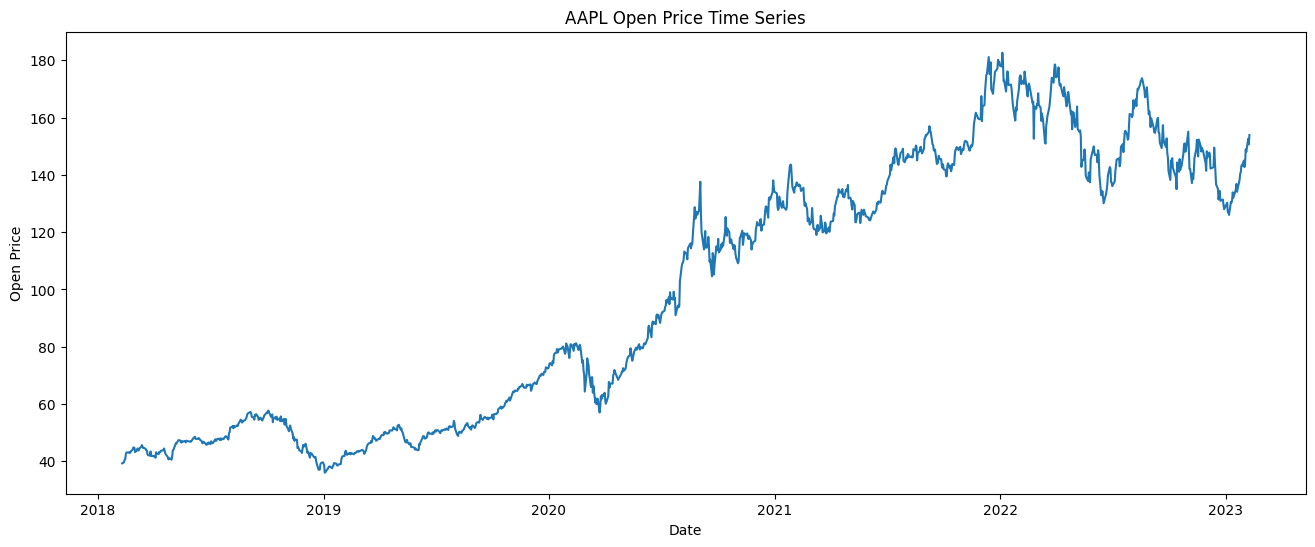

In [17]:
# For showing patterns, trends, fluctuations
# plot the close column data
plt.figure(figsize=(16,6))
plt.plot(df['Open'])
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.title('AAPL Open Price Time Series')
plt.show()

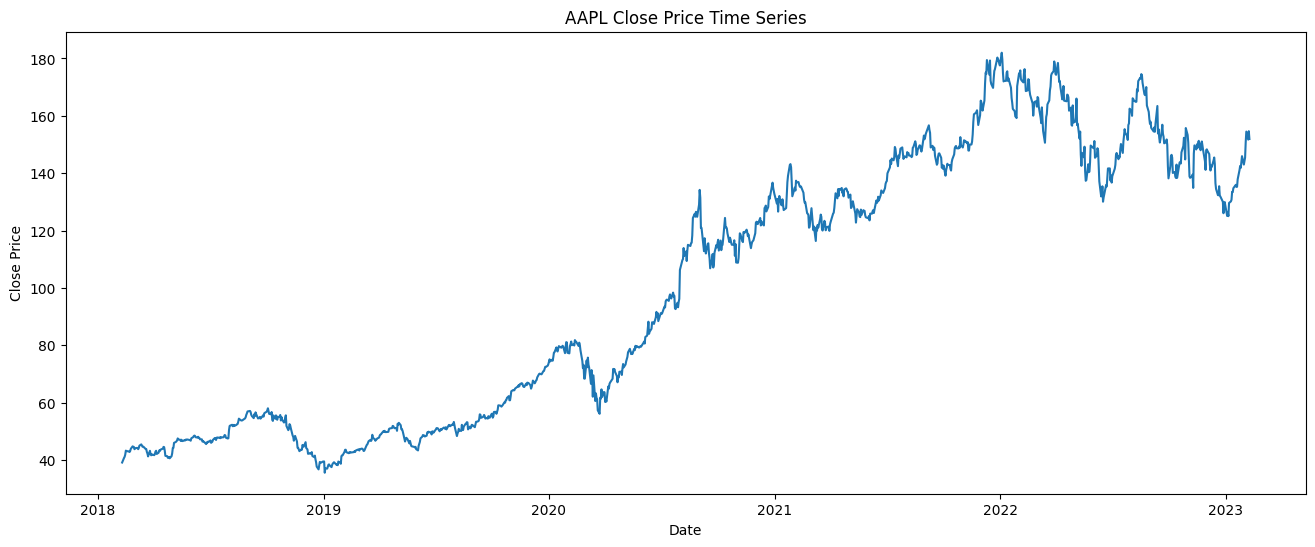

In [18]:
# For showing patterns, trends, fluctuations
# plot the close column data
plt.figure(figsize=(16,6))
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('AAPL Close Price Time Series')
plt.show()

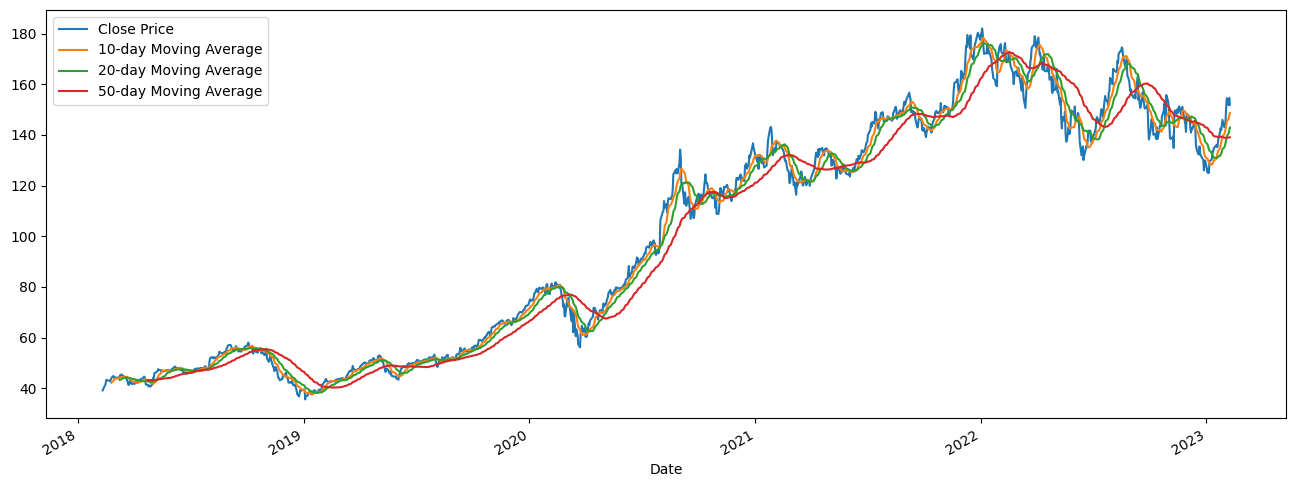

In [19]:
# Calculating Moving Average

# Calculate the 30-day moving average
df['10-day MA'] = df['Close'].rolling(window=10).mean()
df['20-day MA'] = df['Close'].rolling(window=20).mean()
df['50-day MA'] = df['Close'].rolling(window=50).mean()

plt.figure(figsize=(16,6))
df['Close'].plot(label='Close Price')
df['10-day MA'].plot(label='10-day Moving Average')
df['20-day MA'].plot(label='20-day Moving Average')
df['50-day MA'].plot(label='50-day Moving Average')
plt.legend(loc='best')
plt.show()

C:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


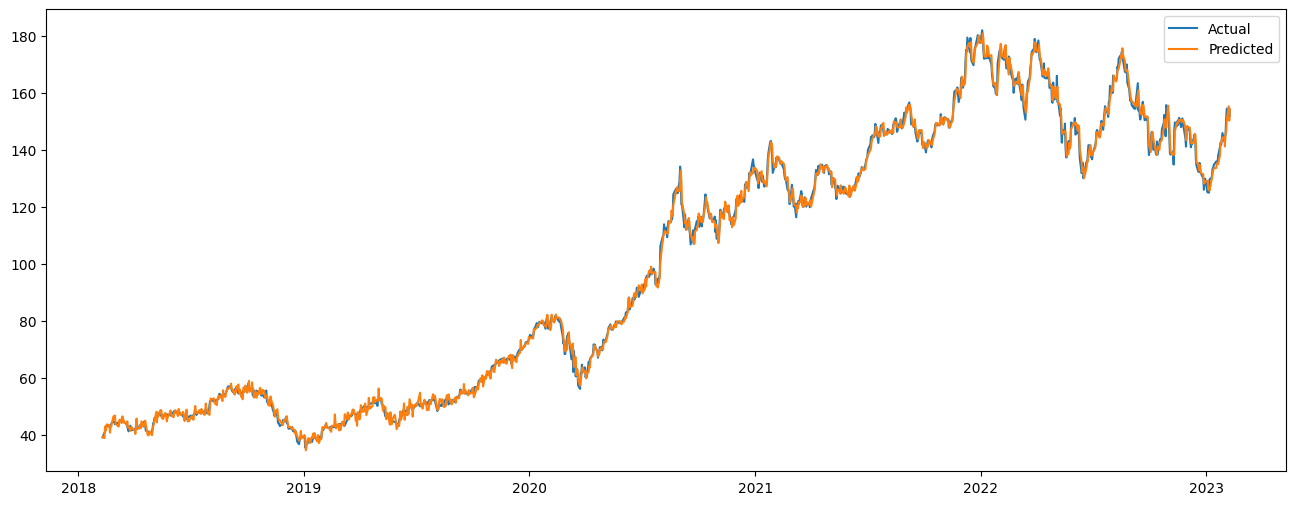

In [20]:
# Exponential smoothing 

# Fit the exponential smoothing model
model = ExponentialSmoothing(df['Close'], seasonal_periods=365, trend='add', seasonal='add').fit()

# Predict the future values
pred = model.predict(start=pd.to_datetime('2018-02-09'), end=pd.to_datetime('2023-02-08'))

# Plot the actual and predicted values
plt.figure(figsize=(16,6))
plt.plot(df['Close'], label='Actual')
plt.plot(pred, label='Predicted')
plt.legend(loc='best')
plt.show();

C:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


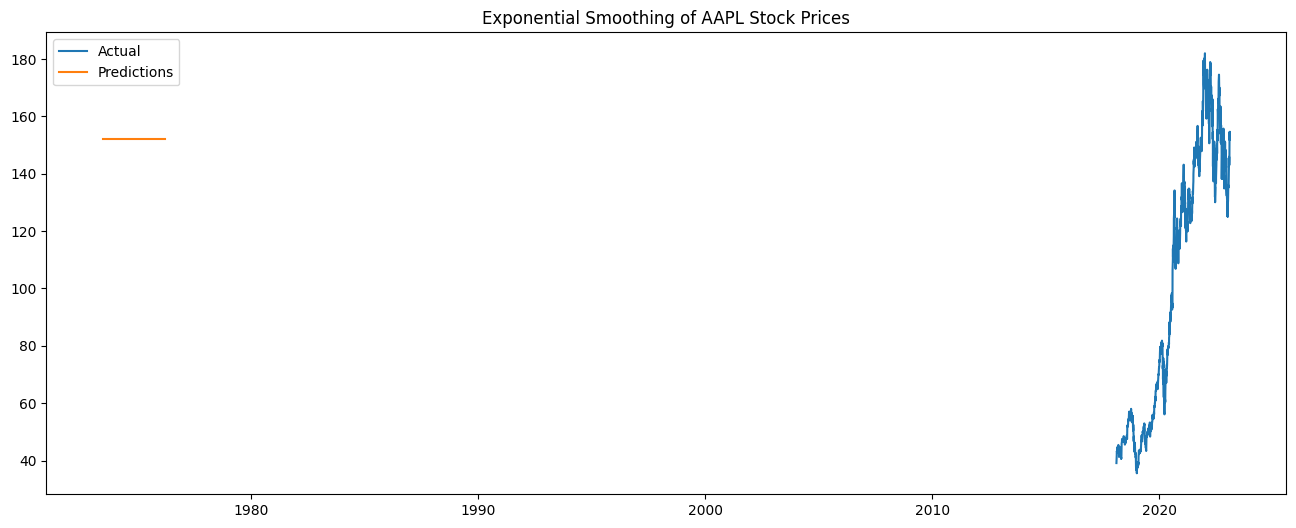

In [21]:
# Fit the SimpleExpSmoothing model
model = SimpleExpSmoothing(df['Close'])
model_fit = model.fit()

# Predict the future values using the fitted model
predictions = model_fit.forecast(steps=1000).rename("Predictions")

# Plot the actual values and the predictions
plt.figure(figsize=(16,6))
plt.plot(df['Close'], label="Actual")
plt.plot(predictions, label="Predictions")
plt.legend(loc="upper left")
plt.title("Exponential Smoothing of AAPL Stock Prices")
plt.show()

C:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


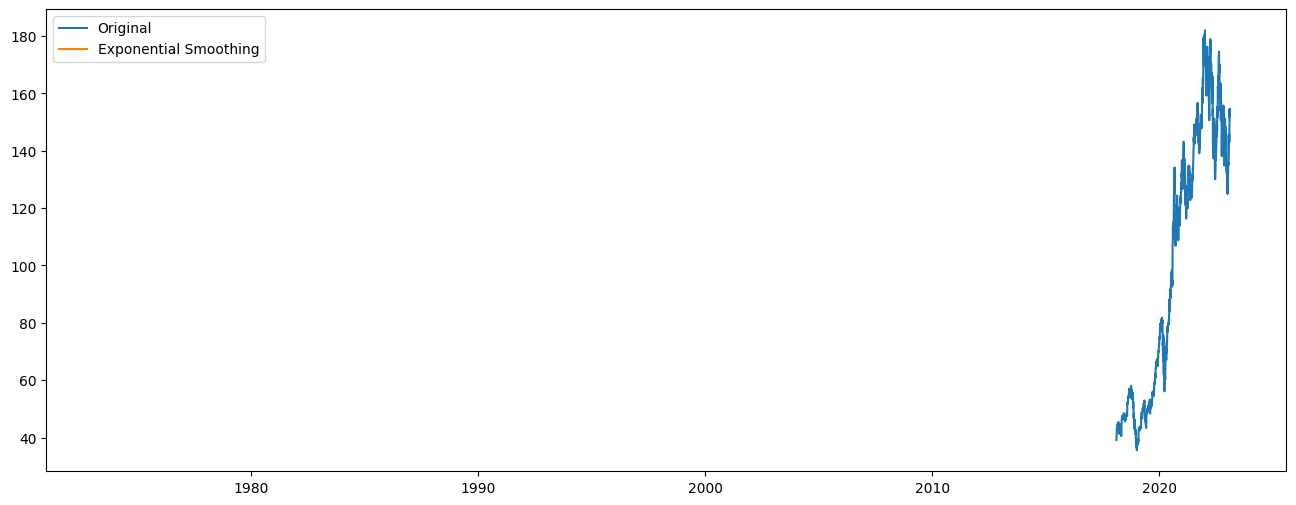

In [22]:
# ExponentialSmoothing
# Select the 'Close' column and fit an exponential smoothing model
close_prices = df['Close']
model = ExponentialSmoothing(close_prices).fit()

# Get the exponential smoothing predictions
predictions = model.predict()

# Plot the original and exponential smoothed data
plt.figure(figsize=(16,6))
plt.plot(close_prices, label='Original')
plt.plot(predictions, label='Exponential Smoothing')
plt.legend()
plt.show()

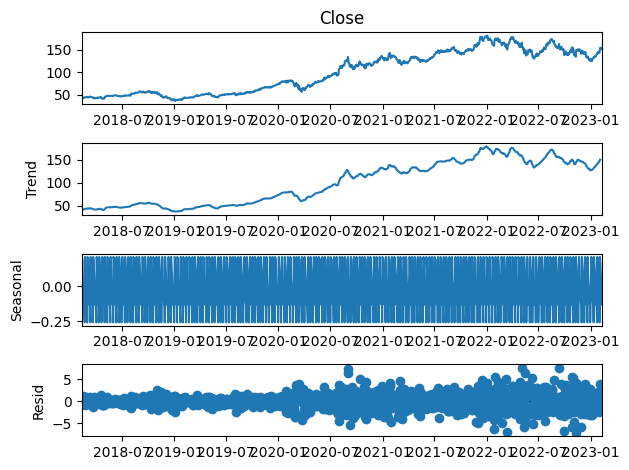

In [23]:

decompose = seasonal_decompose(df['Close'],model='additive', period=7)
decompose.plot()
plt.show()

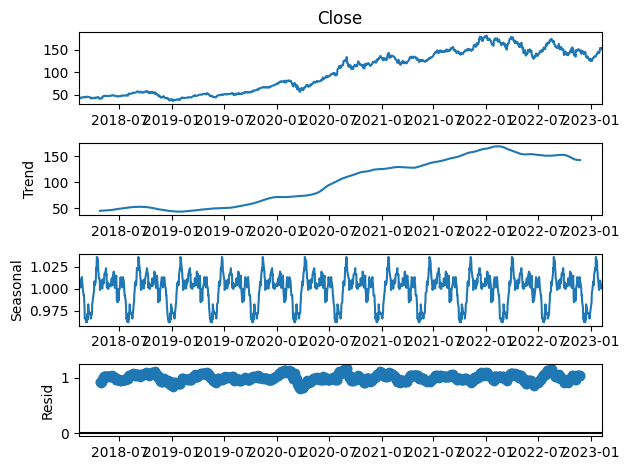

In [24]:
# Plot the seasonality graph of the aapl data set
decompose = seasonal_decompose(df['Close'],model='multiplicative', period=100)
decompose.plot()
plt.show()

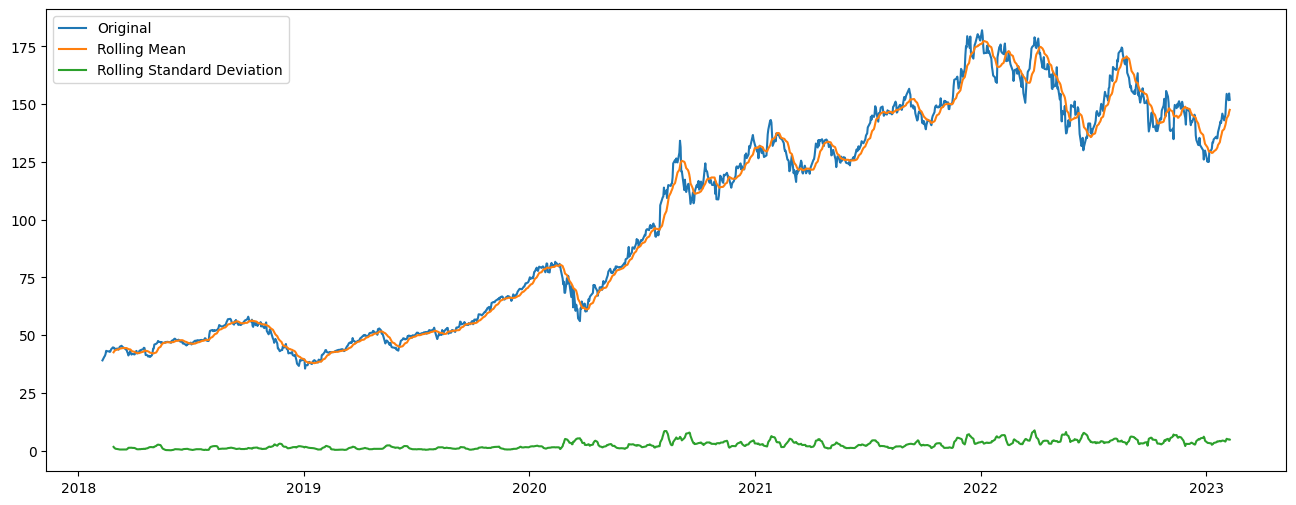

In [25]:
# Calculate the rolling mean and standard deviation over a specified window size
rolling_mean = df['Close'].rolling(window=12).mean()
rolling_std = df['Close'].rolling(window=12).std()

# Plot the original time-series data and its rolling mean and standard deviation
plt.figure(figsize=(16,6))
plt.plot(df['Close'], label='Original')
plt.plot(rolling_mean, label='Rolling Mean')
plt.plot(rolling_std, label='Rolling Standard Deviation')
plt.legend()
plt.show()

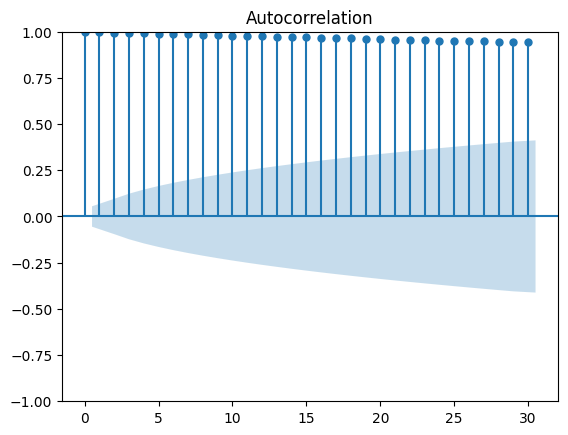

In [26]:
# Plot the autocorrelation graph
plot_acf(df['Close'], lags=30)

# Show the plot
plt.show()

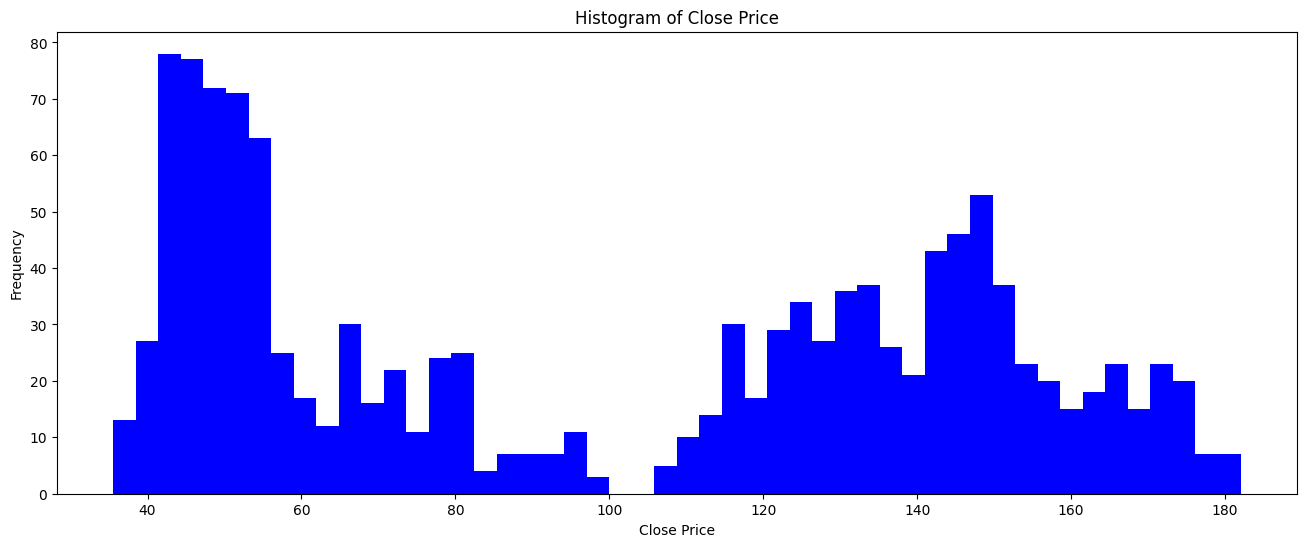

In [27]:
#plotting a histogram of the "Close"
plt.figure(figsize=(16,6))

plt.hist(df['Close'], bins=50, color='blue')
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.title('Histogram of Close Price')
plt.show()

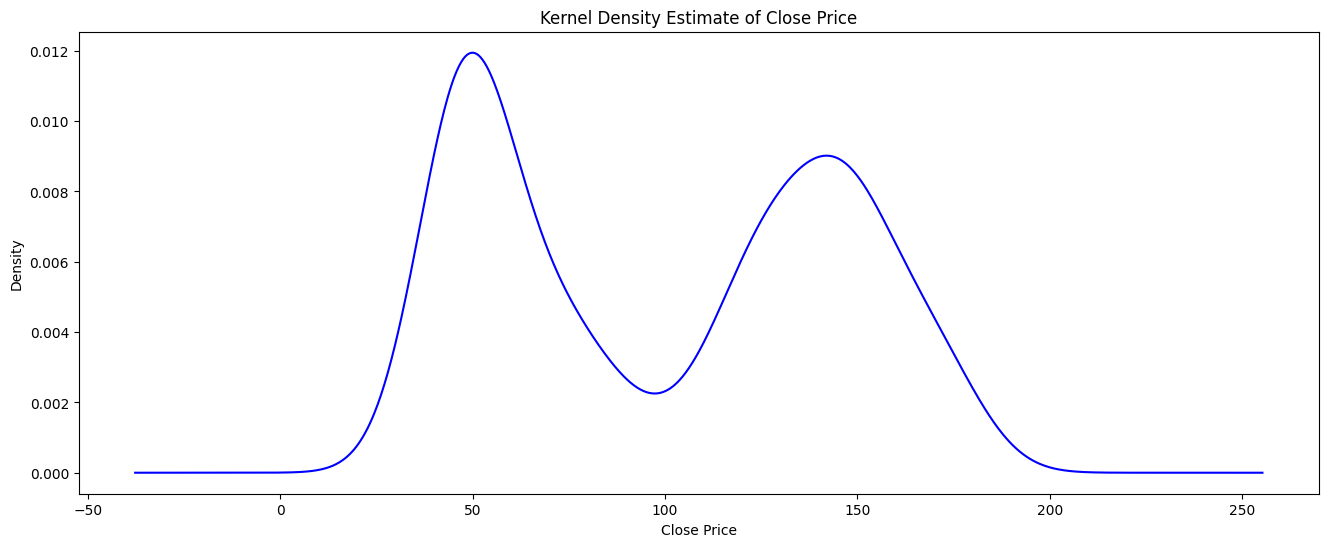

In [28]:
#plotting a kernel density estimate of the "Close"
plt.figure(figsize=(16,6))

df['Close'].plot.kde(color='blue')
plt.xlabel('Close Price')
plt.ylabel('Density')
plt.title('Kernel Density Estimate of Close Price')
plt.show()


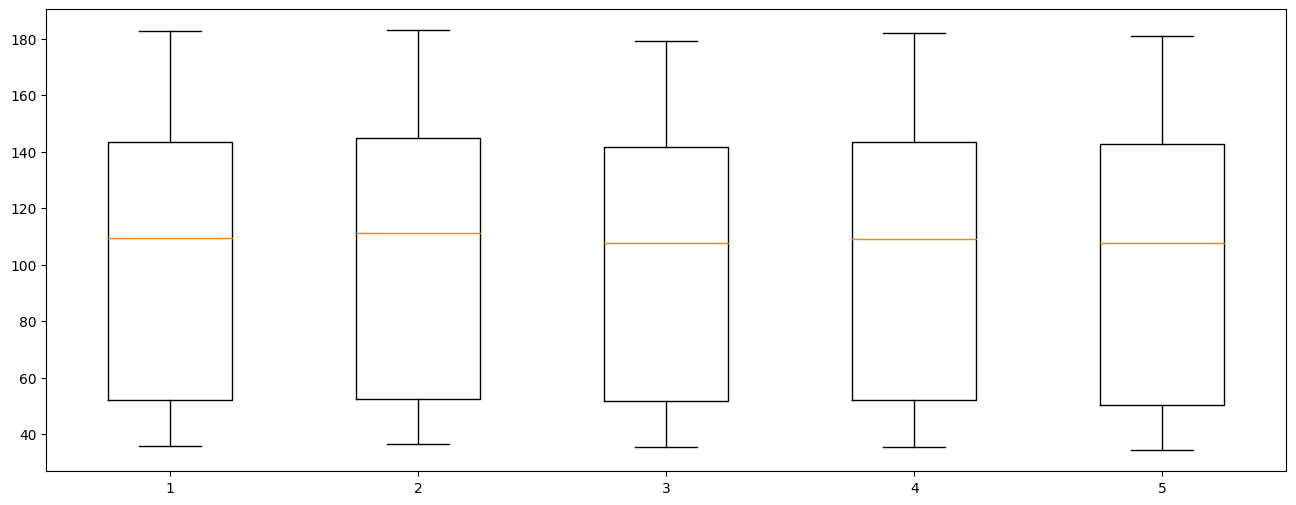

In [29]:
# Create a boxplot of the Close column
# plt.boxplot(df['Close'])
plt.figure(figsize=(16,6))

plt.boxplot(df[['Open','High','Low','Close','Adj Close']])

plt.show()

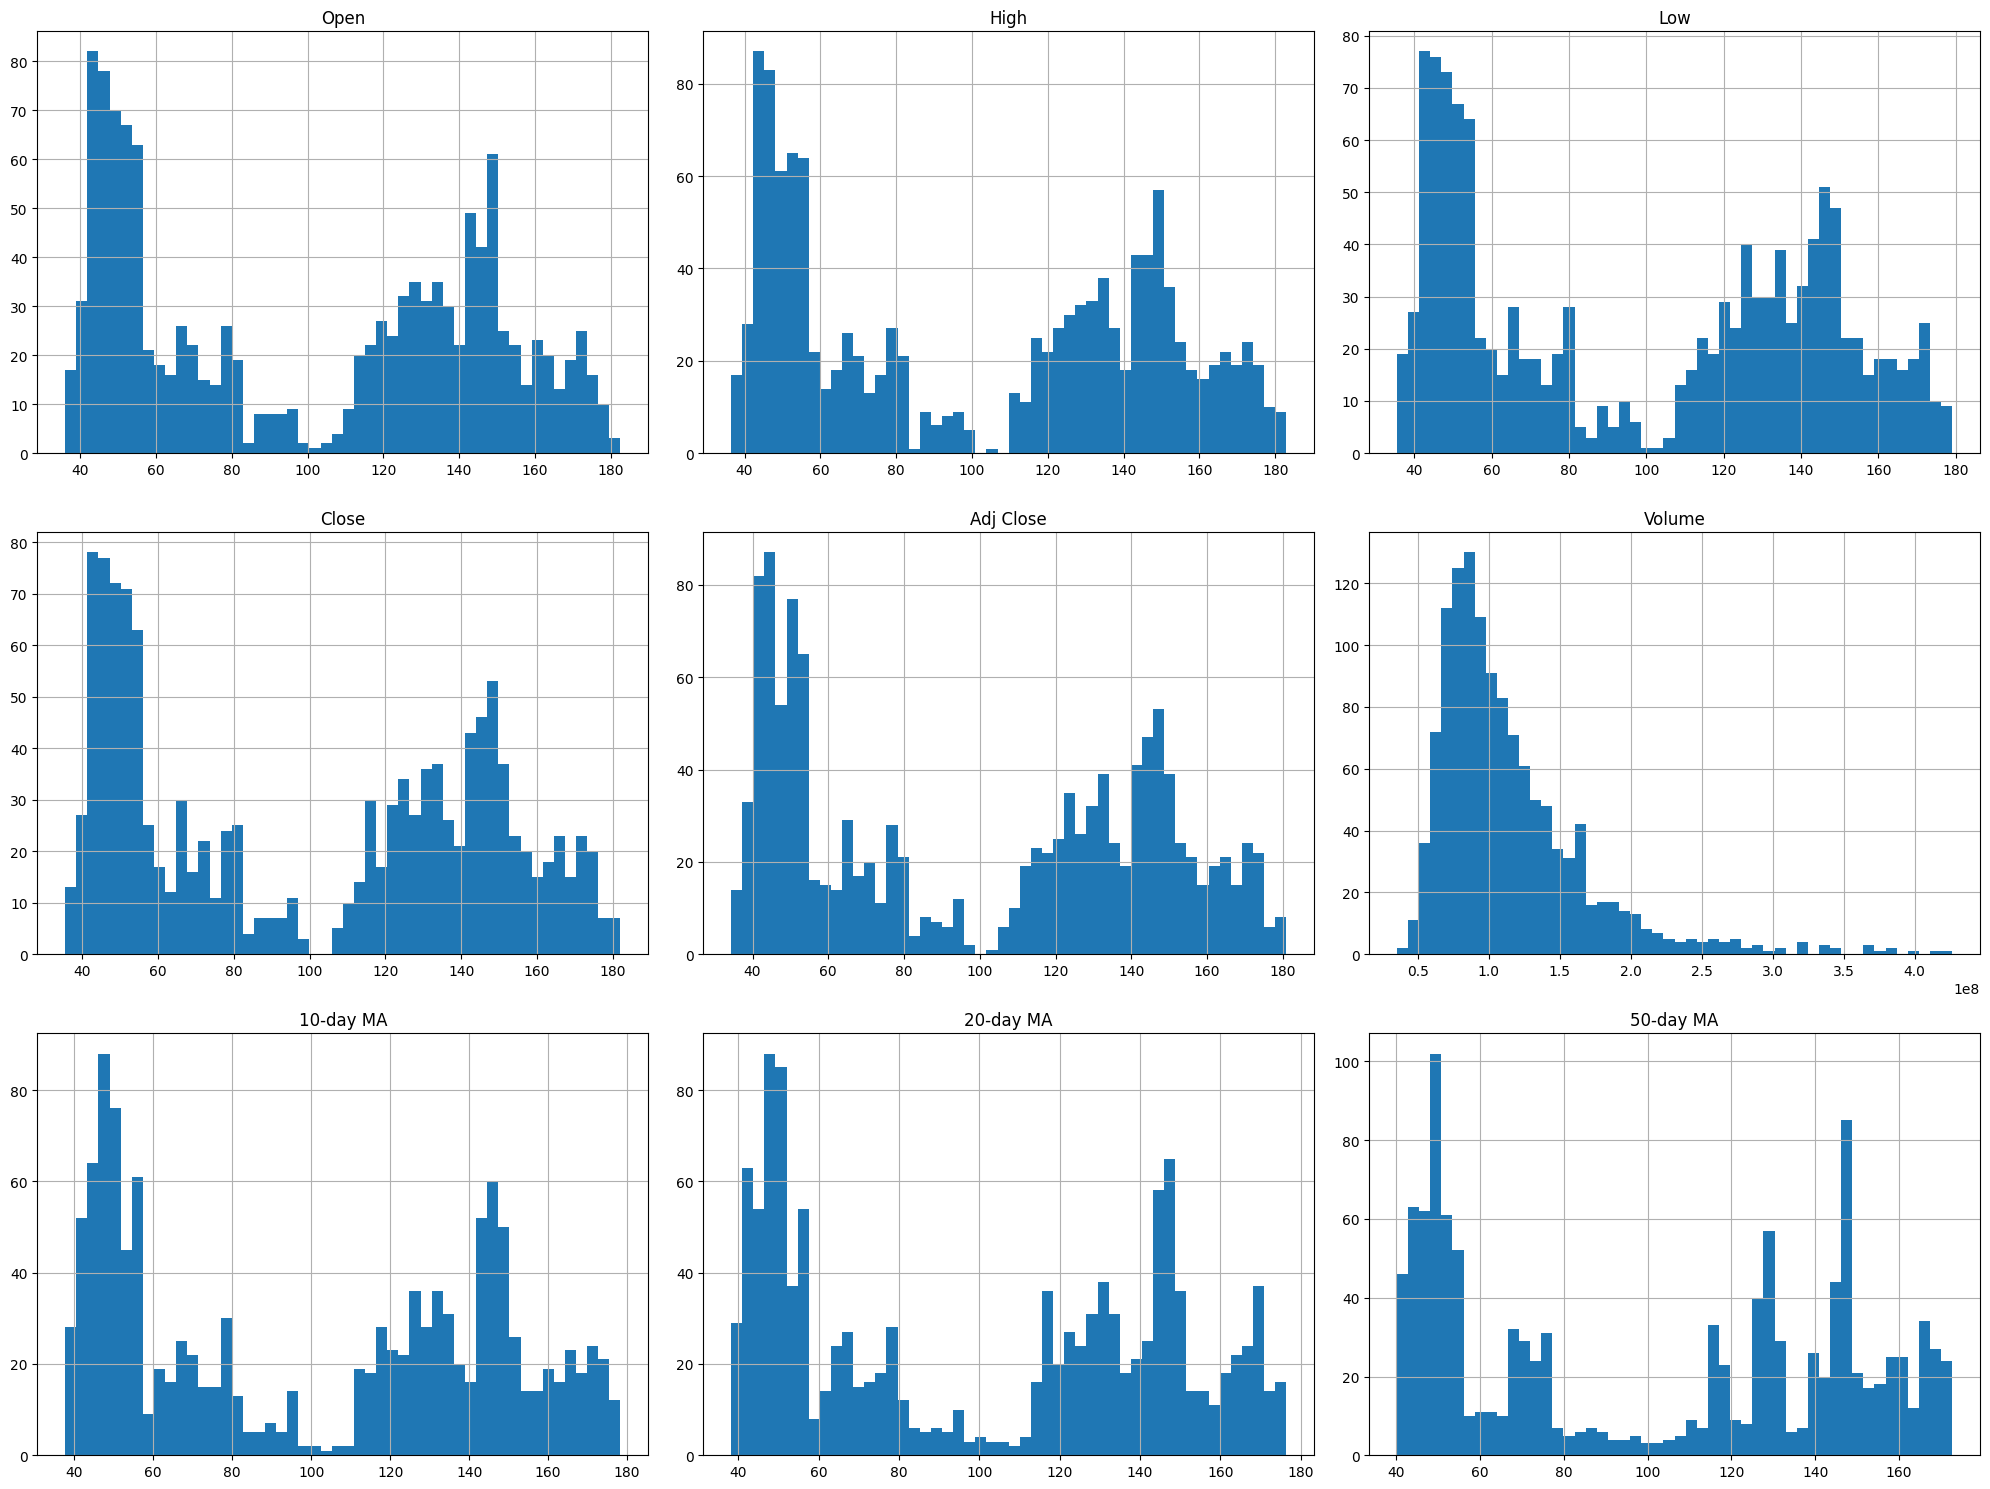

In [30]:
# Plot histograms for each column in the data set
df.hist(bins=50, figsize=(20,15))
plt.tight_layout()
plt.show()

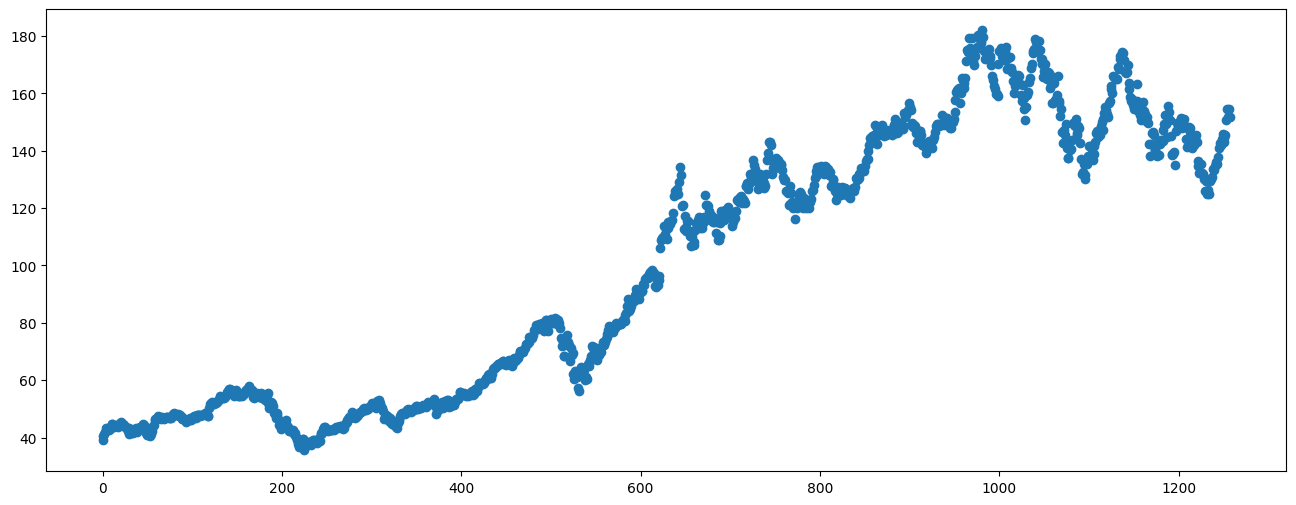

In [31]:
# Plot a scatter plot of the Close column
plt.figure(figsize=(16,6))

plt.scatter(range(df.shape[0]), df['Close'].values)

# Show the plot
plt.show()

In [32]:
# Calculate the Z-score and Outliers

# Calculate the mean and standard deviation of the Close column
mean = df['Close'].mean()
std = df['Close'].std()

# Calculate the Z-score for each data point
df['Z-score'] = (df['Close'] - mean) / std

# Identify outliers based on Z-score
df['Outlier'] = np.where(np.abs(df['Z-score']) > 3, 1, 0)

# Optionally, you can replace the outliers with the mean value or median value
df['Close'] = np.where(np.abs(df['Z-score']) > 3, mean, df['Close'])


In [33]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,10-day MA,20-day MA,50-day MA,Z-score,Outlier
Date,,,,,,,,,,,
2018-02-09,39.267502,39.472500,37.560001,39.102501,37.334156,282690400,NaN,NaN,NaN,-1.327663,0
2018-02-12,39.625000,40.972500,39.377499,40.677502,38.837936,243278000,NaN,NaN,NaN,-1.293401,0
2018-02-13,40.487499,41.187500,40.412498,41.084999,39.226994,130196800,NaN,NaN,NaN,-1.284537,0
2018-02-14,40.759998,41.884998,40.720001,41.842499,39.950245,162579600,NaN,NaN,NaN,-1.268058,0
2018-02-15,42.447498,43.272499,42.250000,43.247501,41.291702,204588800,NaN,NaN,NaN,-1.237495,0


In [34]:
# Identifying outliers using Interquartile range (IQR) and handling it

# Calculate first and third quartiles
Q1 = df['Close'].quantile(0.25)
Q3 = df['Close'].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Calculate lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[(df['Close'] < lower_bound) | (df['Close'] > upper_bound)]

# Handle the outliers
# You can choose to replace the outliers with either Q1 or Q3, or with a mean or median value
df['Close'] = np.where((df['Close'] < lower_bound) | (df['Close'] > upper_bound), df['Close'].median(), df['Close'])


In [35]:
# Checking correlation
correlation_matrix = df.corr()
correlation_matrix

,Open,High,Low,Close,Adj Close,Volume,10-day MA,20-day MA,50-day MA,Z-score,Outlier
Open,1.000000,0.999699,0.999634,0.999208,0.999174,-0.334882,0.997562,0.994089,0.983647,0.999208,NaN
High,0.999699,1.000000,0.999583,0.999634,0.999618,-0.328160,0.997631,0.994334,0.984290,0.999634,NaN
Low,0.999634,0.999583,1.000000,0.999643,0.999595,-0.343715,0.997096,0.993365,0.982877,0.999643,NaN
Close,0.999208,0.999634,0.999643,1.000000,0.999964,-0.336336,0.997008,0.993461,0.983330,1.000000,NaN
Adj Close,0.999174,0.999618,0.999595,0.999964,1.000000,-0.337108,0.997092,0.993684,0.984012,0.999964,NaN
Volume,-0.334882,-0.328160,-0.343715,-0.336336,-0.337108,1.000000,-0.322017,-0.314102,-0.313400,-0.336336,NaN
10-day MA,0.997562,0.997631,0.997096,0.997008,0.997092,-0.322017,1.000000,0.998269,0.988960,0.997008,NaN
20-day MA,0.994089,0.994334,0.993365,0.993461,0.993684,-0.314102,0.998269,1.000000,0.993761,0.993461,NaN
50-day MA,0.983647,0.984290,0.982877,0.983330,0.984012,-0.313400,0.988960,0.993761,1.000000,0.983330,NaN
Z-score,0.999208,0.999634,0.999643,1.000000,0.999964,-0.336336,0.997008,0.993461,0.983330,1.000000,NaN


In [36]:
# Checking for time-series stationarity by Augmented Dickey-Fuller (ADF) test
# Perform the ADF test
result = adfuller(df['Close'])

# Print the test statistic and the p-value
print("ADF Test Statistic: ", result[0])
print("p-value: ", result[1])

ADF Test Statistic:  -0.8881517437292493
p-value:  0.7918491734852535


If the p-value is less than 0.05, it can be assumed that the time-series is stationary. 

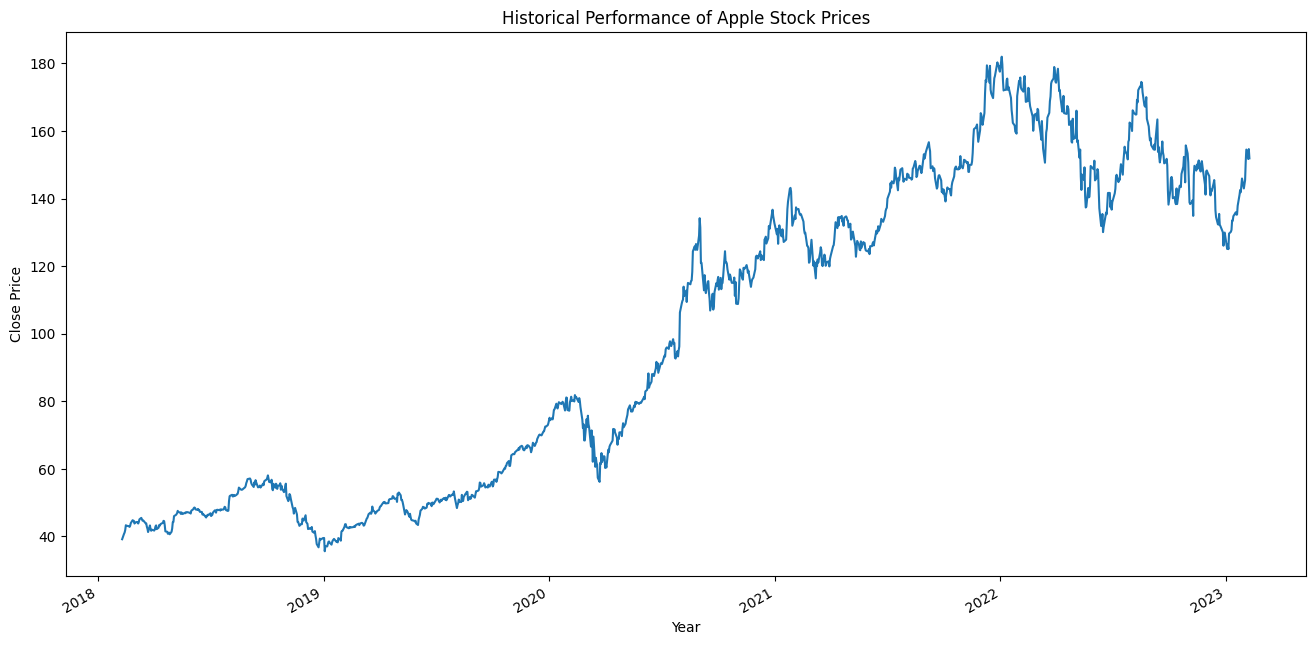

In [37]:
# Plot the Close price
df['Close'].plot(figsize=(16, 8))

# Add a title to the plot
plt.title('Historical Performance of Apple Stock Prices')

# Add labels to the x and y axes
plt.xlabel('Year')
plt.ylabel('Close Price')

# Show the plot
plt.show()

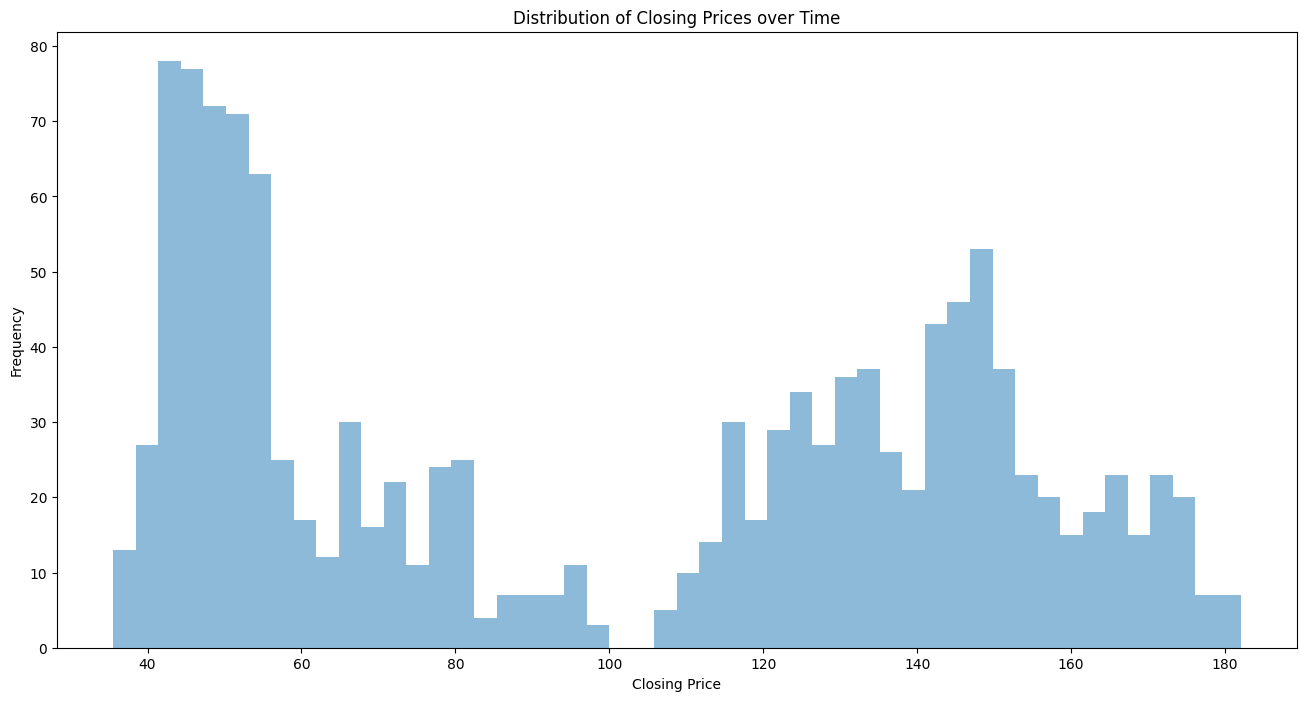

In [38]:
#Visualize the distribution of the data over time.
# Plot the Close price
plt.figure(figsize=(16, 8))

# Plot the histogram of the closing prices
plt.hist(df["Close"], bins=50, alpha=0.5)

# Add labels and title to the plot
plt.xlabel("Closing Price")
plt.ylabel("Frequency")
plt.title("Distribution of Closing Prices over Time")

# Show the plot
plt.show()


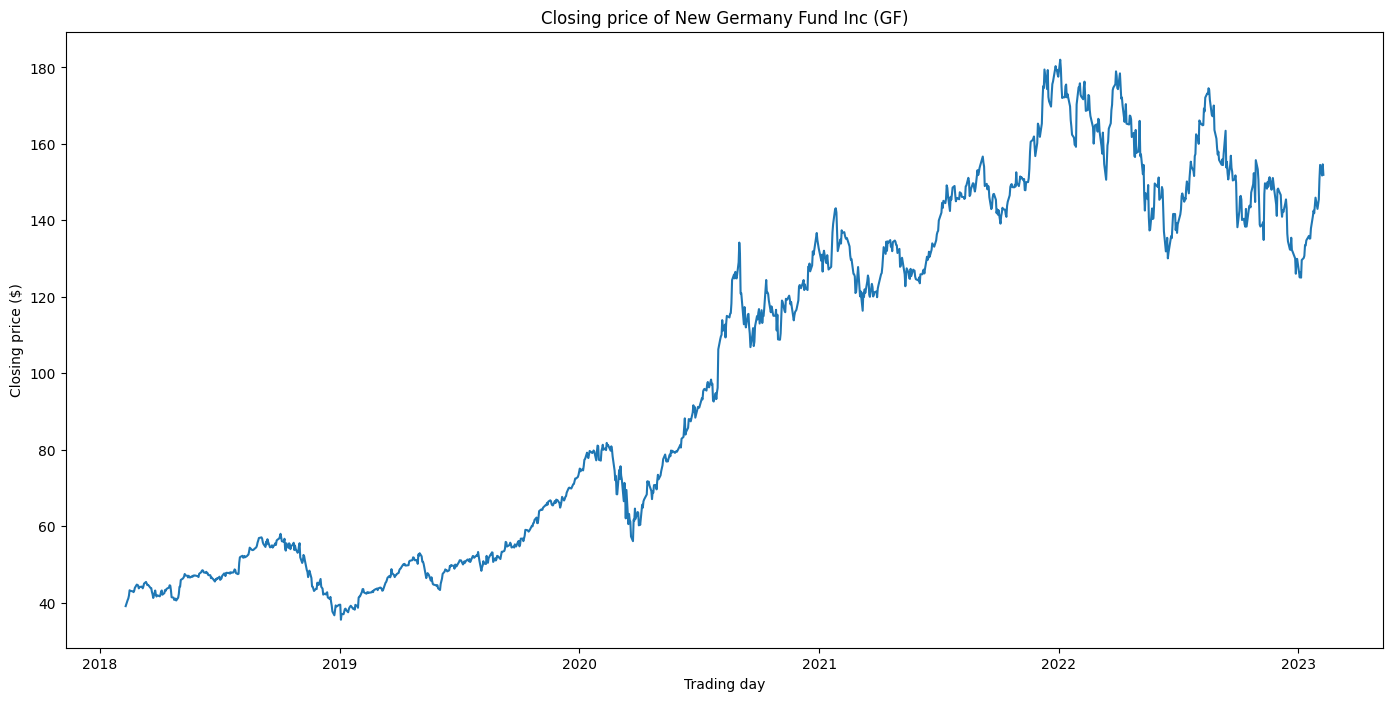

In [39]:
# Plot closing price

plt.figure(figsize=(17, 8))
plt.plot(df.Close)
plt.title('Closing price of New Germany Fund Inc (GF)')
plt.ylabel('Closing price ($)')
plt.xlabel('Trading day')
plt.grid(False)
plt.show()

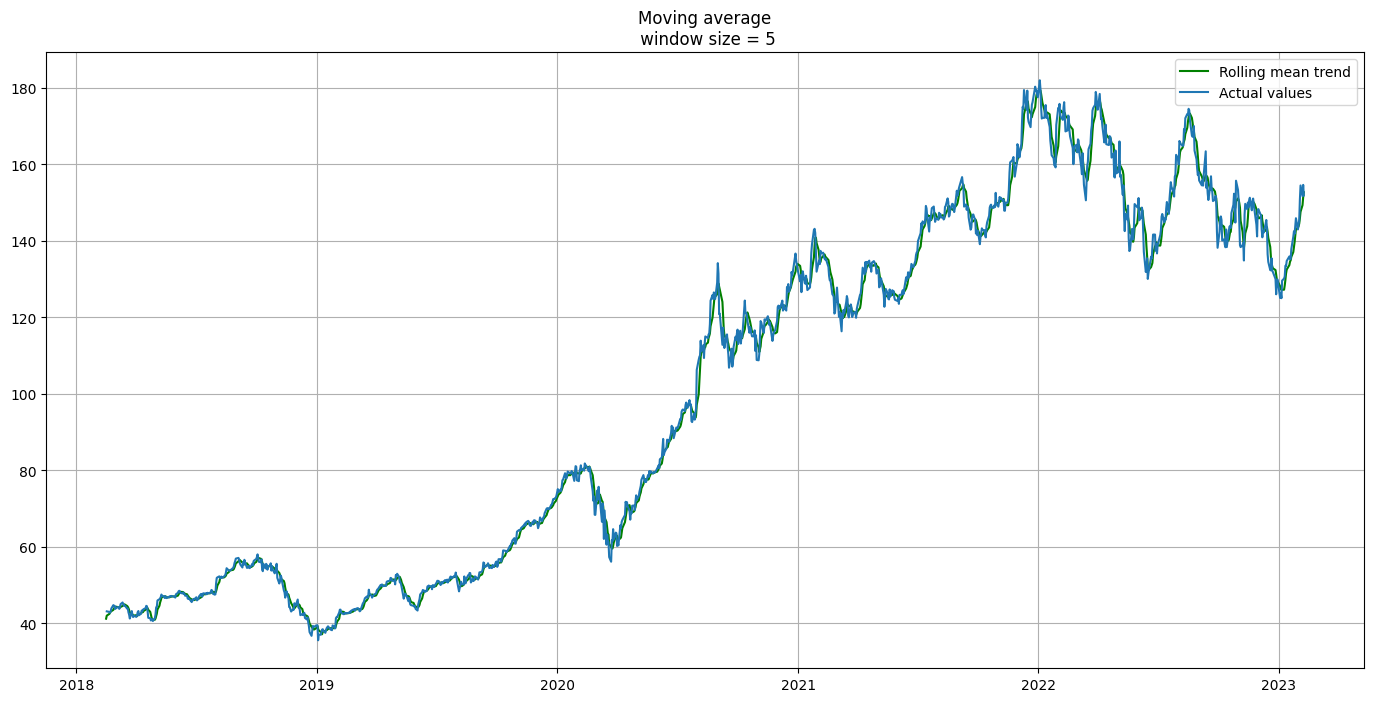

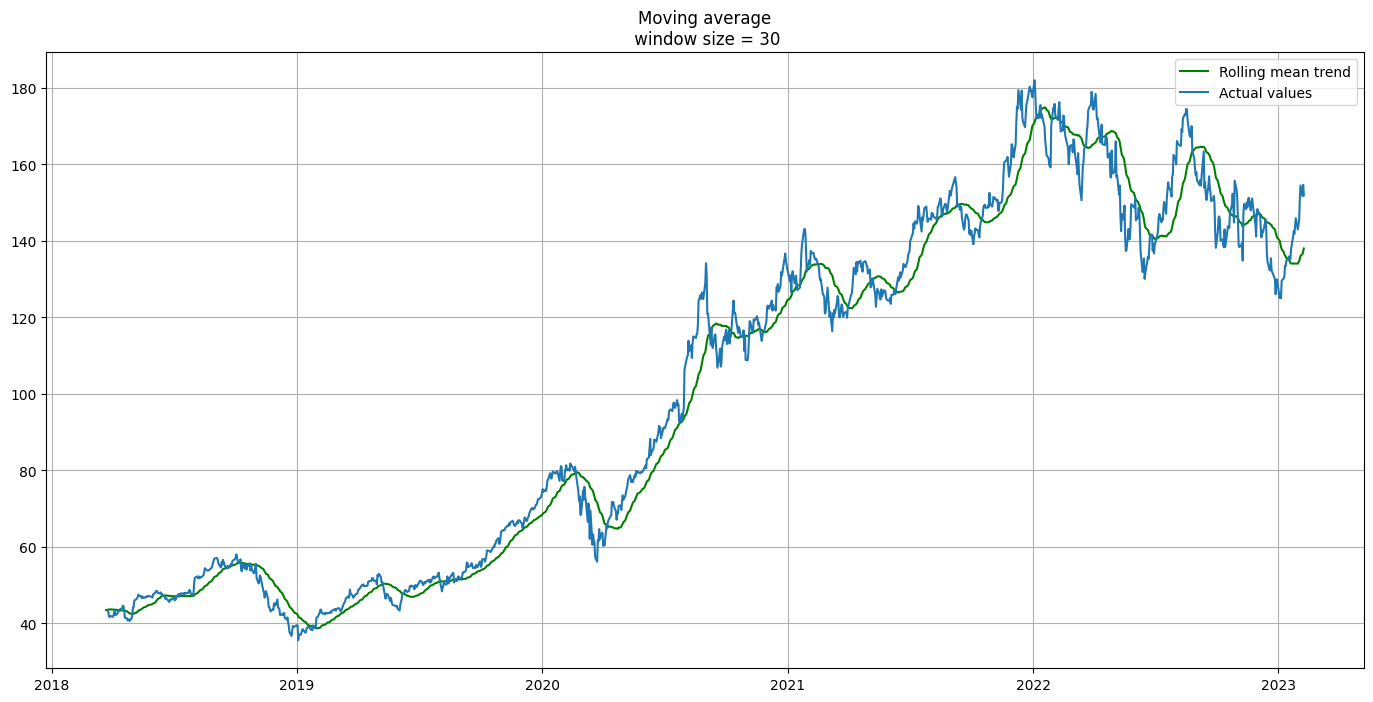

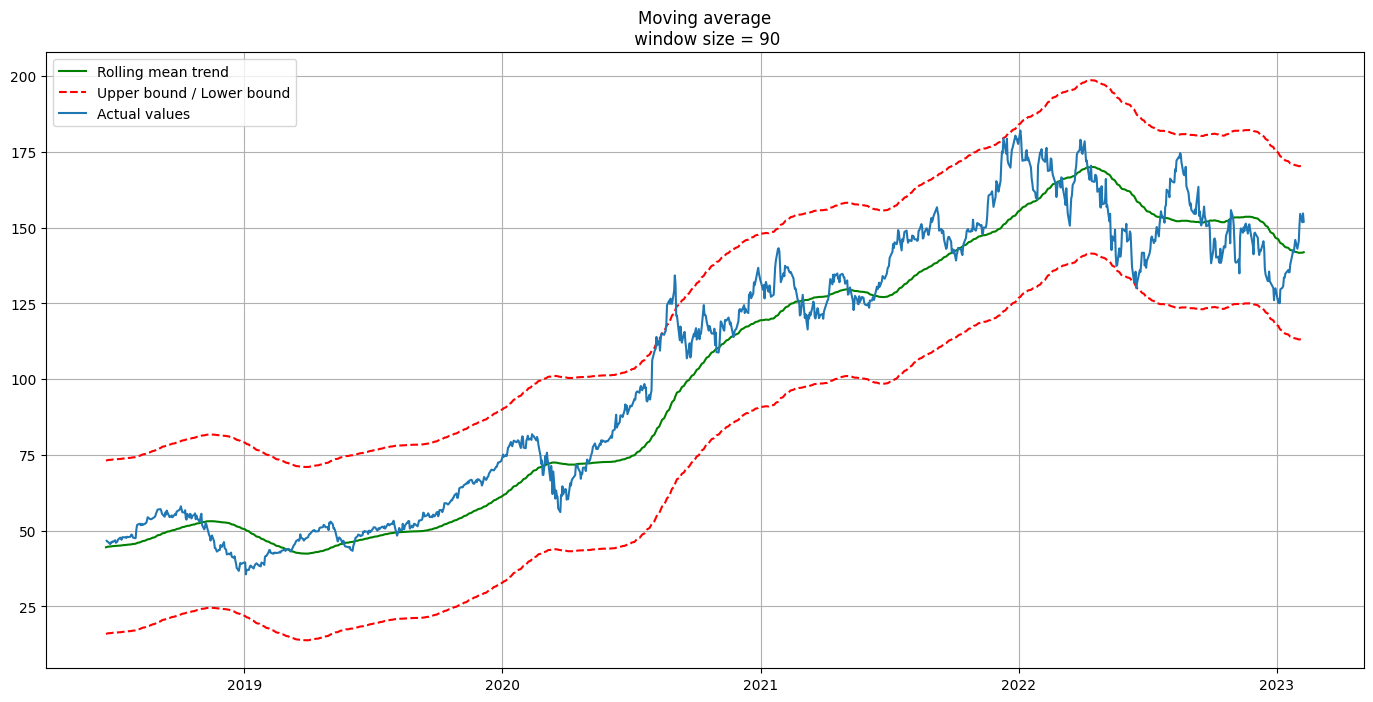

In [40]:
#moving average model to smooth our time series

def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)
    
#Smooth by the previous 5 days (by week)
plot_moving_average(df.Close, 5)

#Smooth by the previous month (30 days)
plot_moving_average(df.Close, 30)

#Smooth by previous quarter (90 days)
plot_moving_average(df.Close, 90, plot_intervals=True)

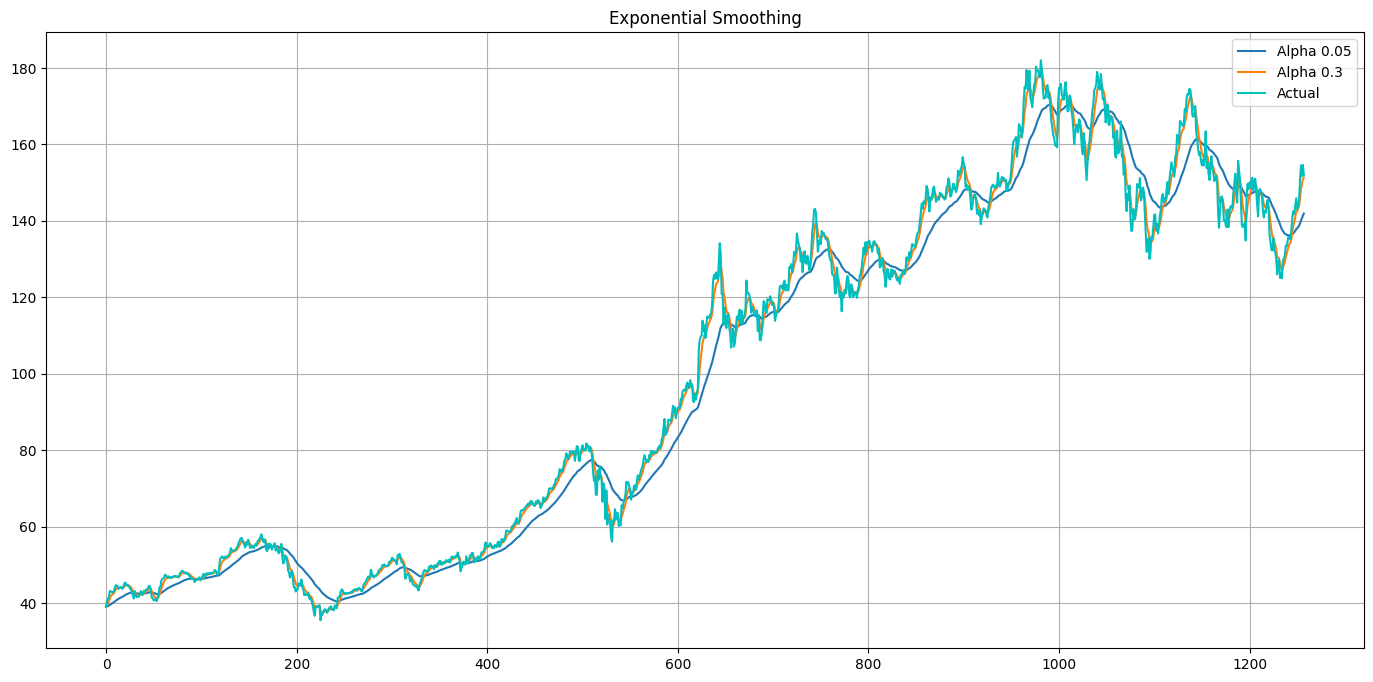

In [41]:
#let’s use exponential smoothing to see if it can pick up a better trend
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
  
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

plot_exponential_smoothing(df.Close, [0.05, 0.3])

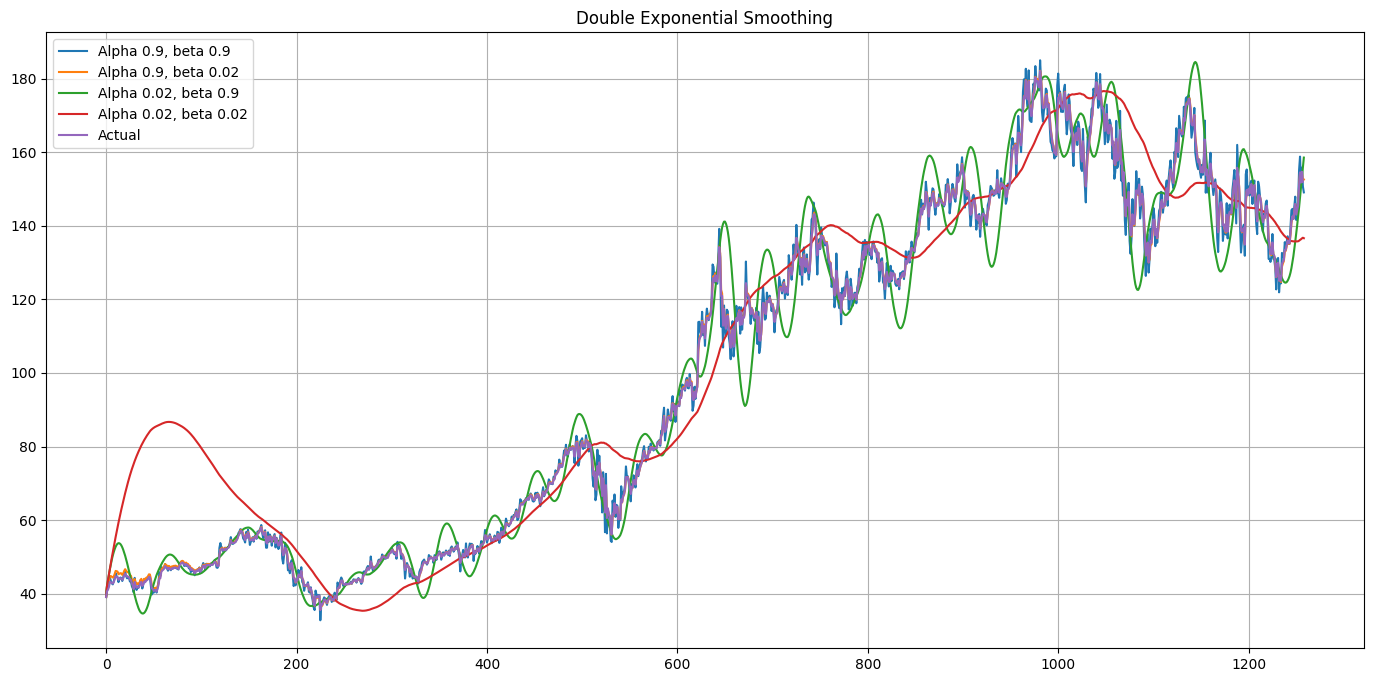

In [42]:
# Double exponential smoothing

def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)
    
plot_double_exponential_smoothing(df.Close, alphas=[0.9, 0.02], betas=[0.9, 0.02])

### 4.Modeling

### Linear Regression

In [43]:

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


In [44]:
X = df['Close']
y = df.index

In [45]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


### Auto ARIMA

In [46]:
from pmdarima.arima import auto_arima

In [47]:
# Fit an ARIMA model with automatic parameter selection
model = auto_arima(df.Close, start_p=1, start_q=1,
                   max_p=3, max_q=3, m=12,
                   start_P=0, seasonal=True,
                   d=1, D=1, trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

# Print the model summary
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=3.73 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=6438.920, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=6096.459, Time=0.38 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=3.37 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=6432.807, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5924.206, Time=0.83 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=11.05 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=4.89 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=5927.220, Time=0.56 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=5925.177, Time=1.17 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=5925.373, Time=2.72 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=5923.921, Time=0.87 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=6096.558, Time=0.32 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=14.28 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC

#### ARIMA

In [48]:
from statsmodels.tsa.arima.model import ARIMA
# statsmodels.tsa.arima.model.ARIMA

In [49]:
train=df.iloc[:-30]
test=df.iloc[-30:]
print(train.shape, test.shape)

(1228, 11) (30, 11)


In [50]:
model=ARIMA(train['Close'], order=(0,1,1))
model=model.fit()
model.summary()

C:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1228
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -2731.857
Date:                Tue, 14 Mar 2023   AIC                           5467.714
Time:                        10:24:29   BIC                           5477.938
Sample:                             0   HQIC                          5471.561
                               - 1228                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0603      0.020     -2.992      0.003      -0.100      -0.021
sigma2         5.0280      0.124     40.428      0.000       4.784       5.272
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               636.44
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):              12.19   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [51]:
model=ARIMA(train['Close'], order=(1,0,5))
model=model.fit()
model.summary()

C:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1228
Model:                 ARIMA(1, 0, 5)   Log Likelihood               -2734.223
Date:                Tue, 14 Mar 2023   AIC                           5484.446
Time:                        10:24:30   BIC                           5525.351
Sample:                             0   HQIC                          5499.837
                               - 1228                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         98.6794     31.969      3.087      0.002      36.021     161.338
ar.L1          0.9990      0.001    826.821      0.000       0.997       1.001
ma.L1         -0.0560      0.021     -2.728      0.006      -0.096      -0.016
ma.L2         -0.0273      0.021     -1.323      0.186      -0.068       0.013
ma.L3         -0.0226      0.023     -0.985      0.324      -0.068       0.022
ma.L4         -0.0005      0.020     -0.027      0.979      -0.039       0.038
ma.L5          0.0548      0.019      2.828      0.005       0.017       0.093
sigma2         5.0042      0.123     40.604      0.000       4.763       5.246
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               669.83
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):              11.81   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [52]:
start=len(train)
end=len(train)+len(test)-1
pred = model.predict(start=start, end=end, type='levels')
# print(pred)
pred.index=df.index[start:end+1]
print(pred)

Date
2022-12-27    131.703674
2022-12-28    131.711917
2022-12-29    131.858428
2022-12-30    131.676650
2023-01-03    131.627635
2023-01-04    131.594402
2023-01-05    131.561202
2023-01-06    131.528036
2023-01-09    131.494903
2023-01-10    131.461804
2023-01-11    131.428738
2023-01-12    131.395705
2023-01-13    131.362706
2023-01-17    131.329740
2023-01-18    131.296807
2023-01-19    131.263907
2023-01-20    131.231041
2023-01-23    131.198207
2023-01-24    131.165407
2023-01-25    131.132640
2023-01-26    131.099906
2023-01-27    131.067205
2023-01-30    131.034537
2023-01-31    131.001902
2023-02-01    130.969300
2023-02-02    130.936731
2023-02-03    130.904194
2023-02-06    130.871691
2023-02-07    130.839220
2023-02-08    130.806782
Name: predicted_mean, dtype: float64


C:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


<Axes: xlabel='Date'>

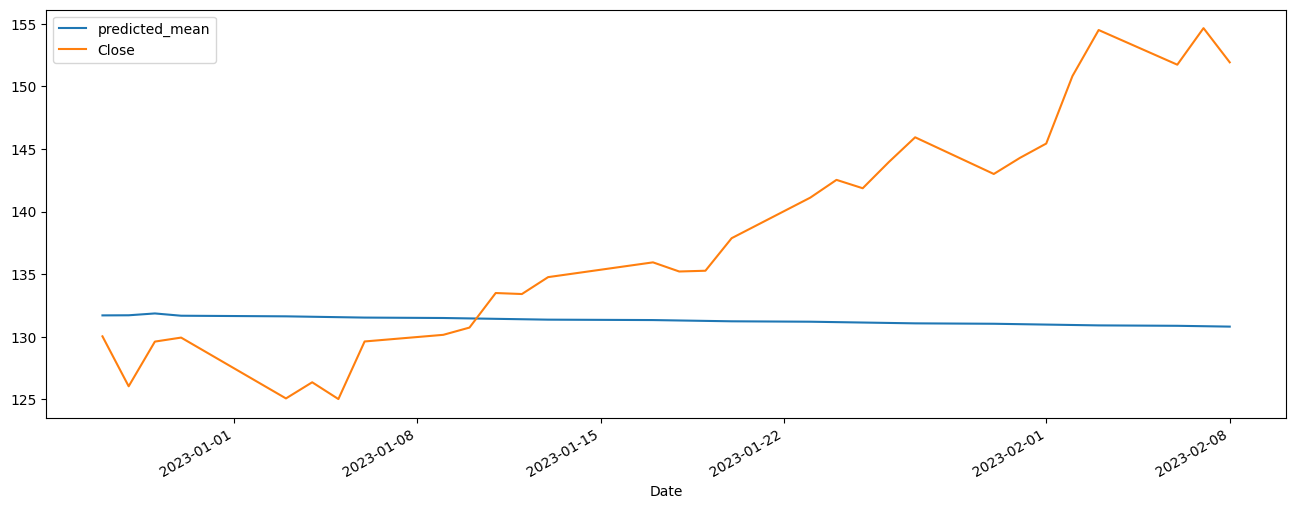

In [53]:
plt.figure(figsize=(16, 6))

pred.plot(legend=True)
test['Close'].plot(legend=True)

In [54]:
test['Close'].mean()

138.00799903333333

In [55]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rmse=sqrt(mean_squared_error(pred, test['Close']))
print(rmse)

11.454699424605161


In [56]:
## For entire data sets

In [57]:
model2=ARIMA(df['Close'], order=(1,0,5))
model2=model2.fit()
df.tail()

C:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,Open,High,Low,Close,Adj Close,Volume,10-day MA,20-day MA,50-day MA,Z-score,Outlier
Date,,,,,,,,,,,
2023-02-02,148.899994,151.179993,148.169998,150.820007,150.820007,118339000,143.679999,138.019999,138.760600,1.102582,0
2023-02-03,148.029999,157.380005,147.830002,154.500000,154.500000,154279900,145.342999,139.494000,138.890400,1.182635,0
2023-02-06,152.570007,153.100006,150.779999,151.729996,151.729996,69858300,146.404999,140.599500,138.921400,1.122378,0
2023-02-07,150.639999,155.229996,150.639999,154.649994,154.649994,83322600,147.616998,141.824500,138.993000,1.185898,0
2023-02-08,153.880005,154.580002,151.169998,151.919998,151.919998,64038100,148.622998,142.884000,139.069199,1.126511,0


In [58]:
index_future_dates=  pd.date_range(start='2023-02-08', end='2023-03-10')
pred = model2.predict(start=len(df), end=len(df)+30, type='levels').rename('ARIMA Predictions')
pred.index=index_future_dates
pred

C:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


2023-02-08    152.293538
2023-02-09    152.528033
2023-02-10    152.343150
2023-02-11    152.497210
2023-02-12    152.260493
2023-02-13    152.197449
2023-02-14    152.134482
2023-02-15    152.071591
2023-02-16    152.008776
2023-02-17    151.946037
2023-02-18    151.883374
2023-02-19    151.820786
2023-02-20    151.758275
2023-02-21    151.695839
2023-02-22    151.633478
2023-02-23    151.571193
2023-02-24    151.508983
2023-02-25    151.446849
2023-02-26    151.384789
2023-02-27    151.322805
2023-02-28    151.260895
2023-03-01    151.199061
2023-03-02    151.137301
2023-03-03    151.075616
2023-03-04    151.014006
2023-03-05    150.952470
2023-03-06    150.891008
2023-03-07    150.829621
2023-03-08    150.768308
2023-03-09    150.707069
2023-03-10    150.645905
Freq: D, Name: ARIMA Predictions, dtype: float64

<Axes: >

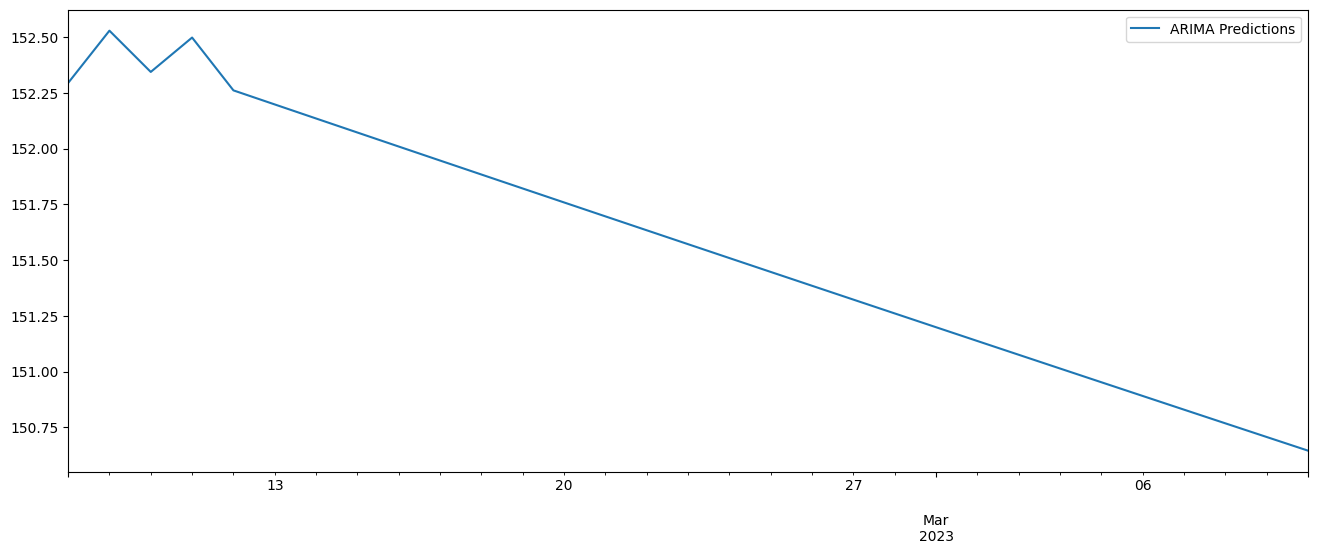

In [59]:
pred.plot(figsize=(16,6), legend=True)

### XGBoost

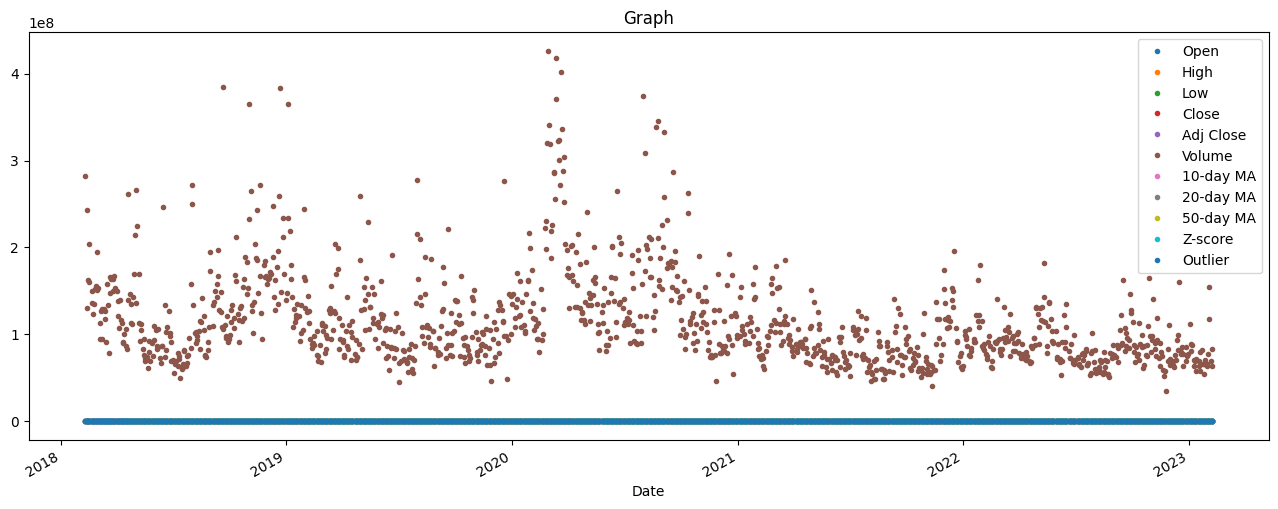

In [60]:
df.plot(style='.',
        figsize=(16,6),
        title = "Graph")
plt.show()

In [61]:
xgtrain=df.iloc[:-30]
xgtest=df.iloc[-30:]
print(xgtrain.shape, xgtest.shape)

(1228, 11) (30, 11)


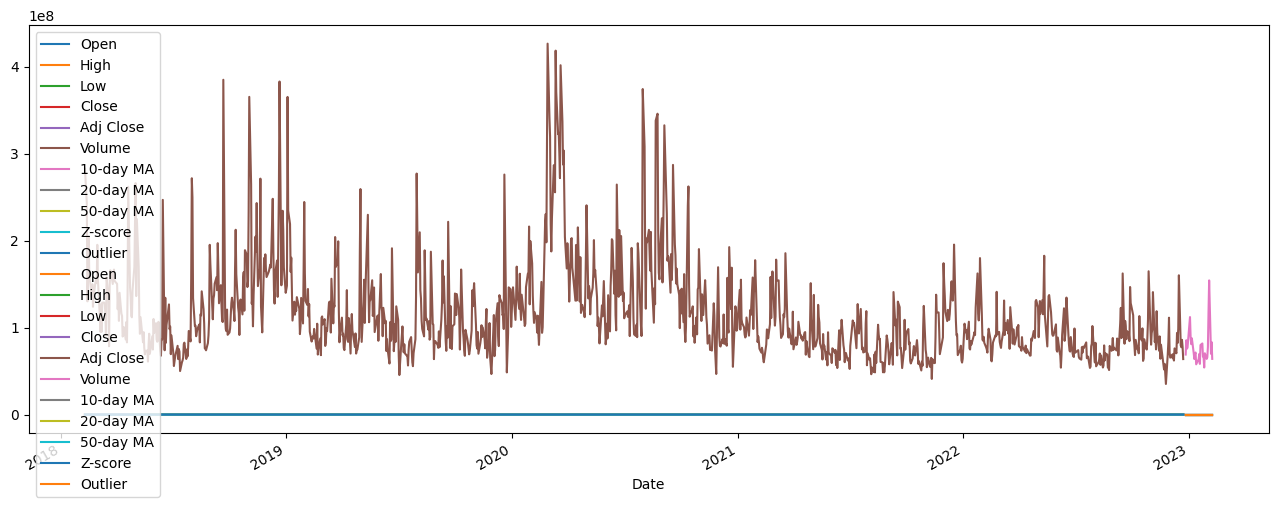

In [62]:
fig, ax = plt.subplots(figsize=(16,6))
train.plot(ax=ax, label='Training Set')
test.plot(ax=ax, label='Test Set')
plt.show()

### 3.Visualization 

<Axes: xlabel='Date'>

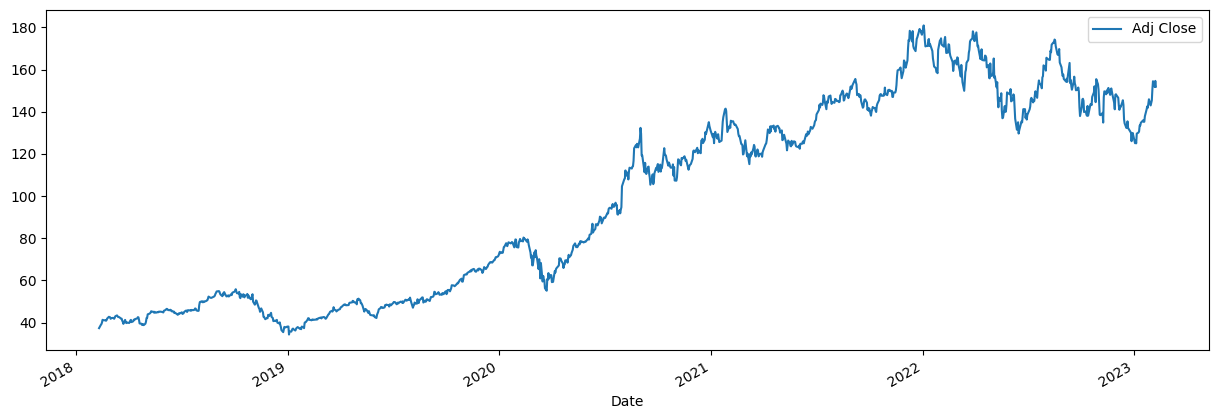

In [63]:
df['Adj Close'].plot(legend=True, figsize=(15,5))

<Axes: xlabel='Date'>

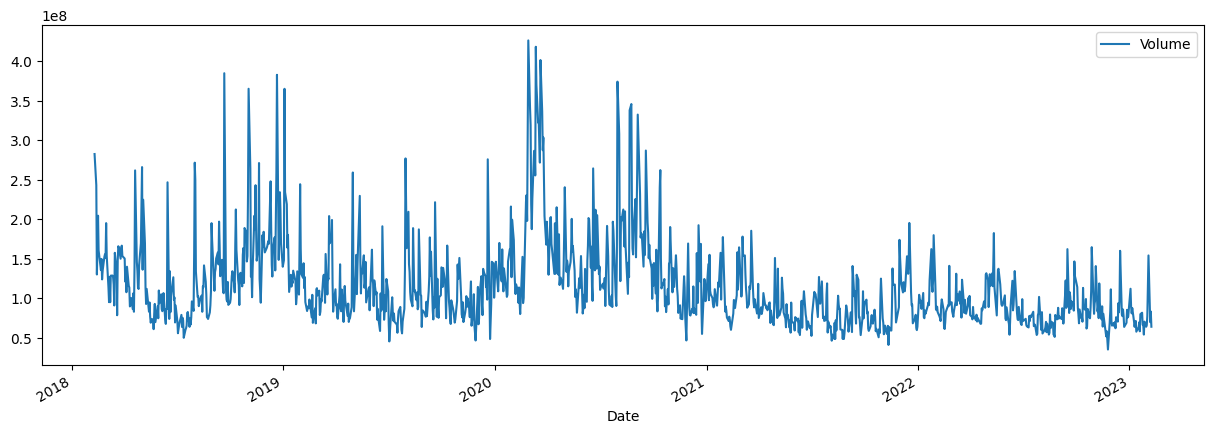

In [64]:
df['Volume'].plot(legend=True, figsize=(15,5))

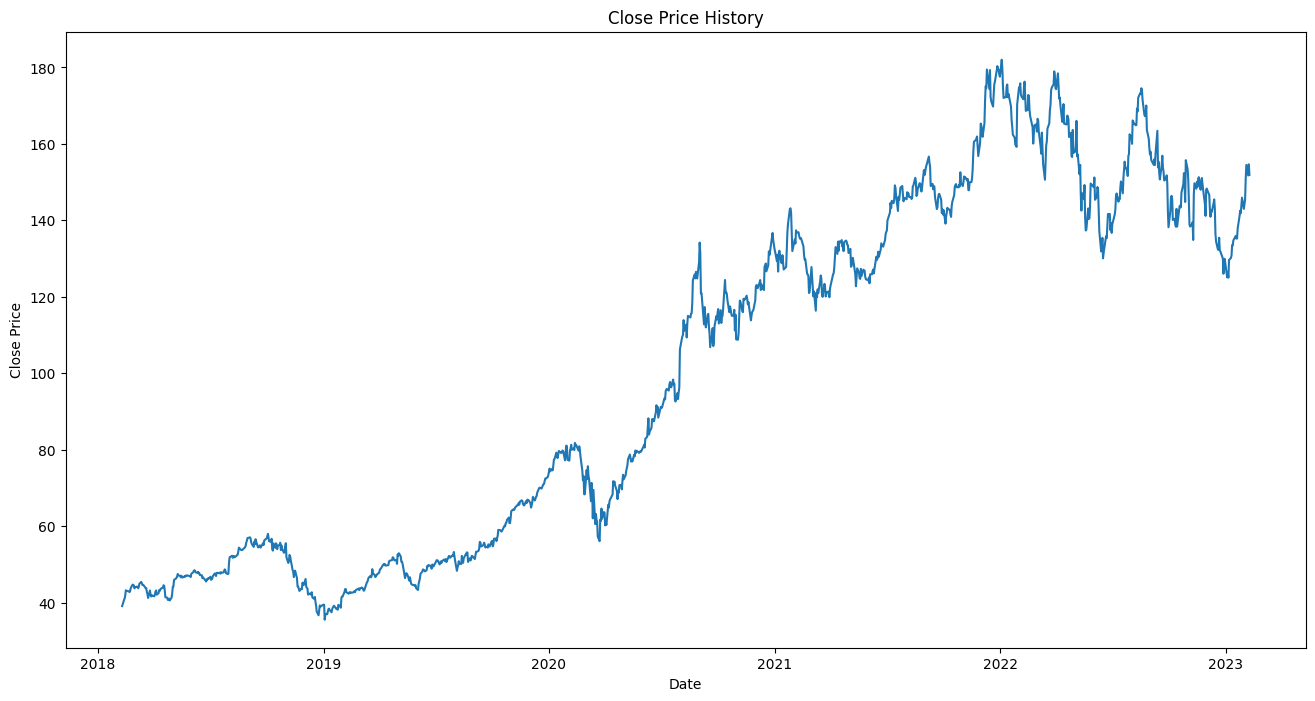

In [65]:
plt.figure(figsize=(16,8))
plt.plot(df["Close"])
plt.title("Close Price History")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

In [66]:
## Create a functin to calculate simple moving average

def sma(df, period = 30, column="Close"):
    return df[column].rolling(window=period).mean()

In [67]:
df.sample(10)

,Open,High,Low,Close,Adj Close,Volume,10-day MA,20-day MA,50-day MA,Z-score,Outlier
Date,,,,,,,,,,,
2020-01-31,80.232498,80.669998,77.072502,77.377502,75.805000,199588400,79.372501,78.123625,72.381500,-0.495048,0
2020-09-04,120.070000,123.699997,110.889999,120.959999,119.319328,332607200,126.348247,120.851749,106.864499,0.453023,0
2021-09-08,156.979996,157.039993,153.979996,155.110001,153.990204,74420200,152.170999,150.372500,147.067800,1.195905,0
2018-08-31,56.627499,57.217499,56.500000,56.907501,54.734760,173360400,54.762000,53.626000,50.048950,-0.940342,0
2019-02-28,43.580002,43.727501,43.230000,43.287498,41.959236,112861600,43.119749,42.865875,40.364500,-1.236625,0
2019-12-11,67.202499,67.775002,67.125000,67.692497,66.316818,78756800,66.572500,66.335001,62.826100,-0.705731,0
2020-07-23,96.997498,97.077499,92.010002,92.845001,91.420830,197004400,96.450500,94.277624,87.419500,-0.158576,0
2018-10-12,55.105000,55.720001,54.209999,55.527500,53.407455,161351600,56.111250,55.634000,54.809600,-0.970362,0
2022-04-12,168.020004,169.869995,166.639999,167.660004,166.904938,79265200,172.766000,170.980502,168.083801,1.468911,0


In [68]:
df.isnull().sum()

Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
10-day MA     9
20-day MA    19
50-day MA    49
Z-score       0
Outlier       0
dtype: int64

In [69]:
df.dropna()

,Open,High,Low,Close,Adj Close,Volume,10-day MA,20-day MA,50-day MA,Z-score,Outlier
Date,,,,,,,,,,,
2018-04-23,41.707500,41.730000,41.022499,41.310001,39.441833,146062000,43.255500,42.793750,43.176000,-1.279642,0
2018-04-24,41.417500,41.582500,40.305000,40.735001,38.892826,134768000,42.997751,42.670875,43.208650,-1.292150,0
2018-04-25,40.654999,41.355000,40.602501,40.912498,39.062298,113528400,42.778000,42.612250,43.213350,-1.288289,0
2018-04-26,41.029999,41.432499,40.842499,41.055000,39.198357,111852000,42.530000,42.584000,43.212750,-1.285189,0
2018-04-27,41.000000,41.082500,40.157501,40.580002,38.744846,142623200,42.219751,42.515750,43.187500,-1.295522,0
...,...,...,...,...,...,...,...,...,...,...,...
2023-02-02,148.899994,151.179993,148.169998,150.820007,150.820007,118339000,143.679999,138.019999,138.760600,1.102582,0
2023-02-03,148.029999,157.380005,147.830002,154.500000,154.500000,154279900,145.342999,139.494000,138.890400,1.182635,0
2023-02-06,152.570007,153.100006,150.779999,151.729996,151.729996,69858300,146.404999,140.599500,138.921400,1.122378,0


In [70]:
df['sma20'] =sma(df, 20)
df['sma50'] =sma(df, 50)

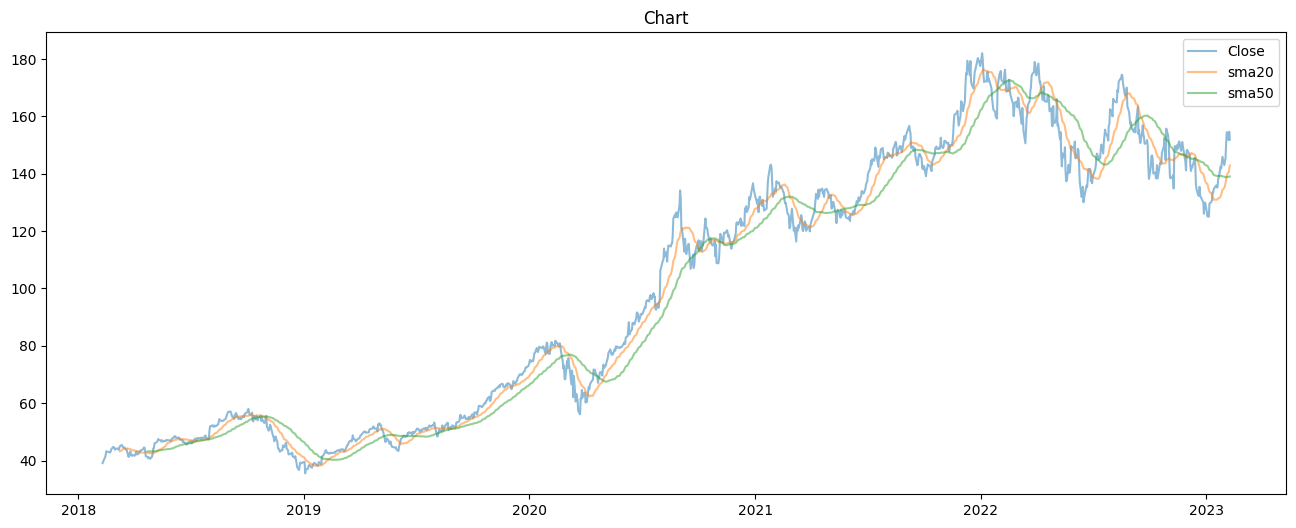

In [71]:
plt.figure(figsize=(16,6))
plt.plot(df["Close"], alpha=.5, label='Close')
plt.plot(df["sma20"], alpha=.5, label='sma20')
plt.plot(df["sma50"], alpha=.5, label='sma50')

plt.title("Chart")
# plt.xlabel("Date")
# plt.ylabel("Close Price")
plt.legend()

<Axes: xlabel='Date'>

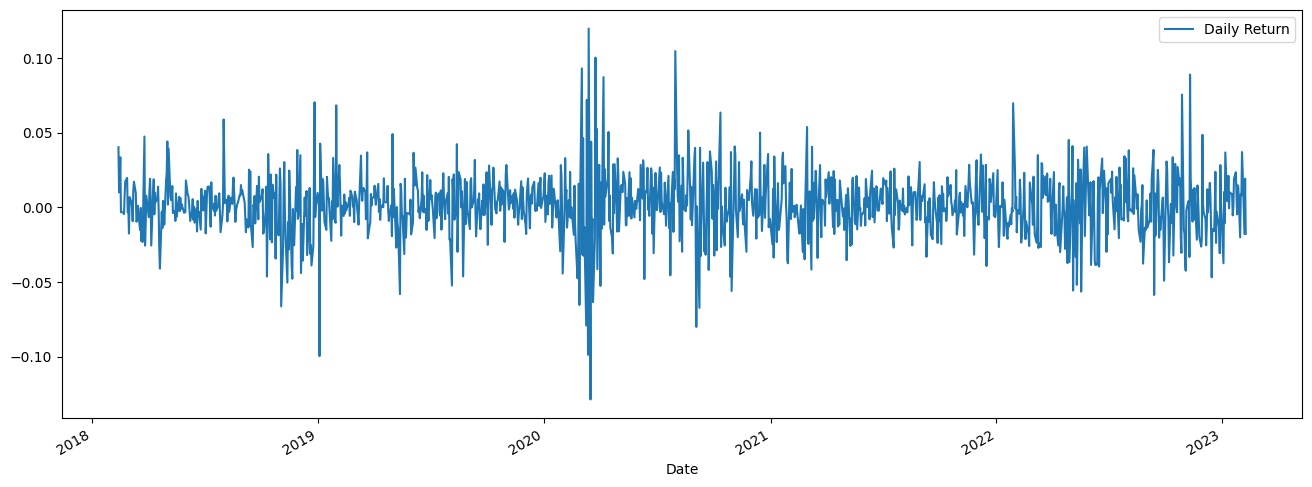

In [72]:
df['Daily Return'] = df['Adj Close'].pct_change()
df['Daily Return'].plot(legend=True, figsize=(16,6))

C:\Users\admin\AppData\Local\Temp\ipykernel_11192\2076043732.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Daily Return'].dropna(), bins=100);


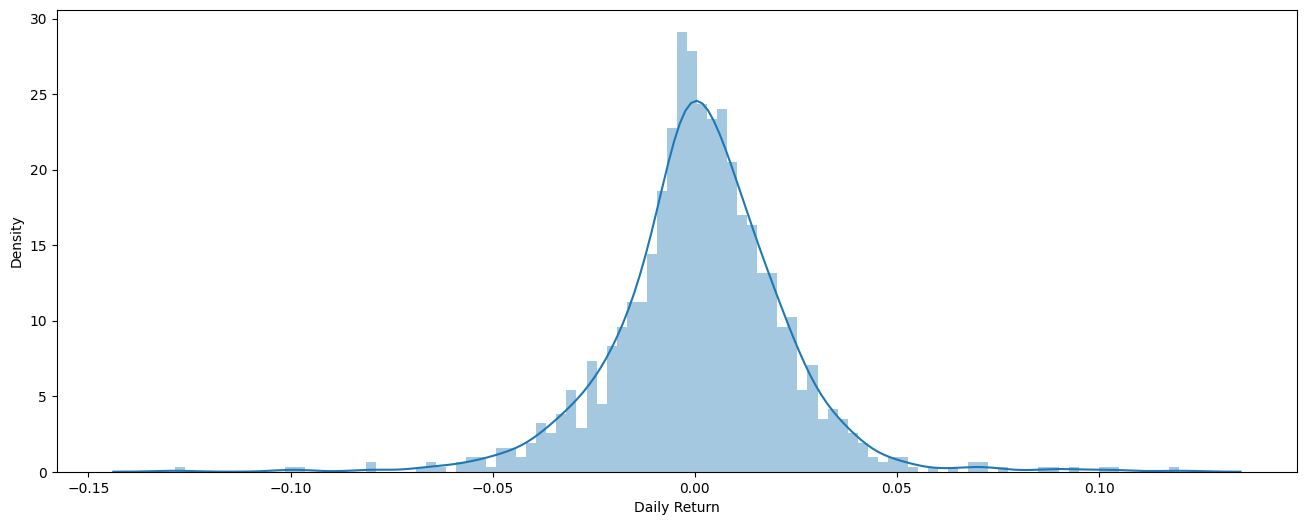

In [73]:
plt.figure(figsize=(16,6))
sns.distplot(df['Daily Return'].dropna(), bins=100);